# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [94]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv
from ipyvolume import pylab
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

In [95]:
df = pd.read_csv("eshop.csv")

In [96]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


# Příprava data frame

In [97]:
orfm = df.copy()
orfm["Date"] = pd.to_datetime(orfm["Date"])
orfm["recency"] = orfm["Date"].max() - orfm["Date"]
orfm["frequency"] = 1

# rename columns
orfm["id"] = orfm["Customer ID"]
orfm["monetary"] = orfm["Subtotal"]
del orfm["Customer ID"]
del orfm["Subtotal"]

rfm = orfm.groupby(["id"]).agg({"recency": "min", "frequency": "sum", "monetary": "sum"})
rfm["recency"] = rfm["recency"].dt.days
display(rfm.head())
display("pocty nevalidnich hodnot")
rfm.isnull().sum()

,recency,frequency,monetary
id,,,
7,311,3,15.54
9,3050,1,13.20
30,3025,1,36.20
34,3103,1,86.00
38,3097,1,38.40


'pocty nevalidnich hodnot'

recency      0
frequency    0
monetary     0
dtype: int64

# Shlukování

In [125]:
# the interactive 3D plots don't support automatic cluster colouring,
# hence the need for a custom palette
colours = np.array([
    [110, 1, 137], # purple
    [13, 83, 163], # blue
    [2, 211, 89], # green
    [242, 219, 42], # yellow
    [42, 211, 56],
    [211, 56, 42],
    [56, 42, 211],
    [211, 42, 56],
    [42, 56, 211]
]) / 255

def plot_interactive_3d_scatter(title, df, clusters):
    f = pylab.figure(title = title)
    pylab.xlabel("recency")
    pylab.ylabel("frequency")
    pylab.zlabel("monetary")
    pylab.scatter(
        # make sure they're all floats
        df.recency.array + 0.0, df.frequency.array + 0.0, df.monetary.array + 0.0,
        color = colours[clusters],
        size = 18,
        marker = "point_2d"
    )
    display(title, f)

def plot_3d_scatter(title, df, clusters):
    f = plt.figure(figsize = (7, 5), dpi = 110)
    f.suptitle(title)
    p = f.add_subplot(projection = '3d')
    p.set_xlabel("recency")
    p.set_ylabel("frequency")
    p.set_zlabel("monetary")
    p.scatter(df.recency, df.frequency, df.monetary, c = clusters, s = 3)

def plot_kmeans(df):
    result = []
    for n in range(2, 7):
        kmeans = KMeans(n, random_state = 42).fit(df)
        prediction = kmeans.predict(df)
        result.append(prediction)
        plot_3d_scatter("k-means pro k = " + str(n), df, prediction)
    return result

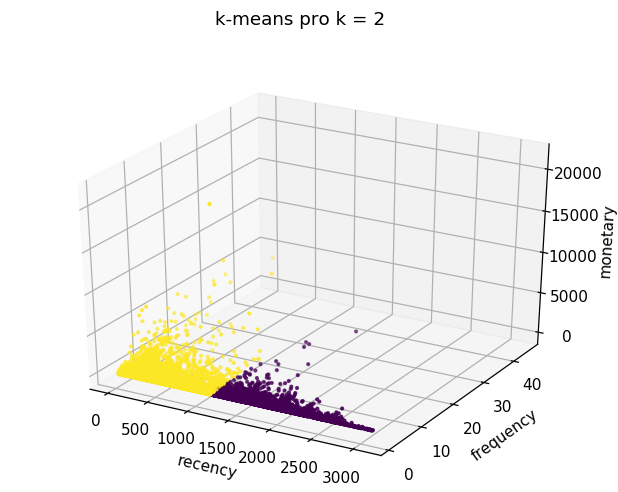

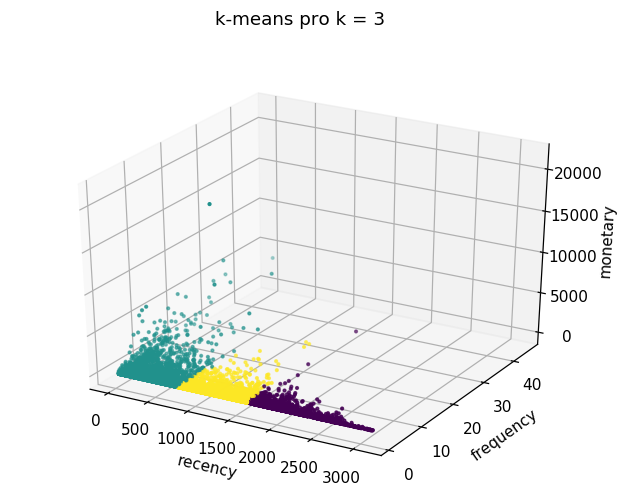

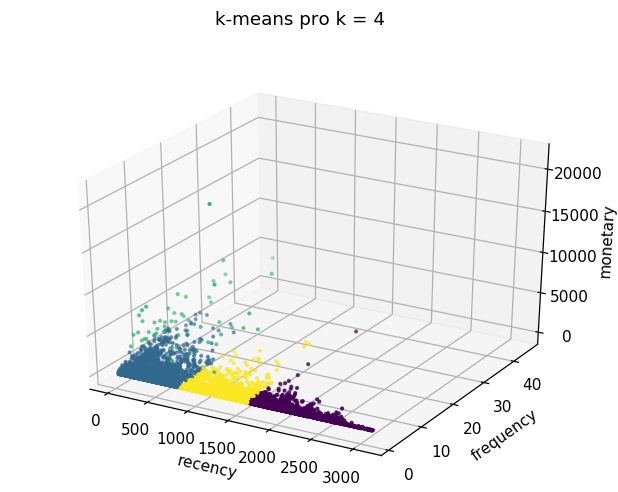

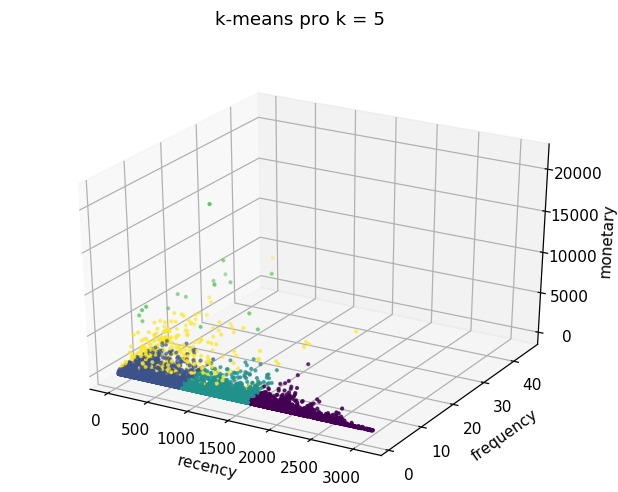

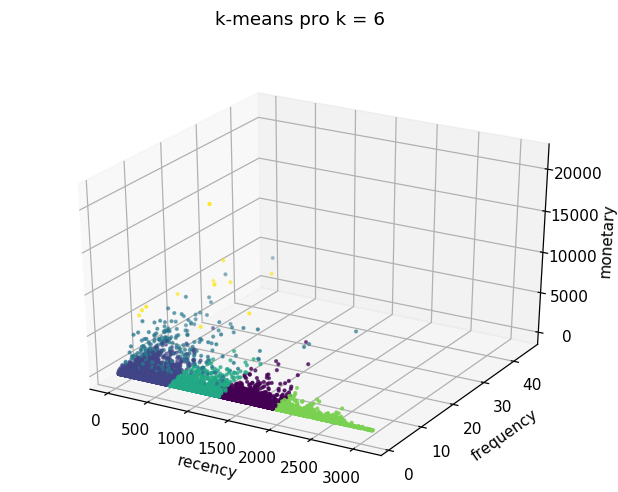

In [115]:
_ = plot_kmeans(rfm)

# Přeškálování
kNN je metoda náchylná na rozdíly v jednotkách jednotlivých příznaků. Z toho důvodu by to data očividně chtělo přeškálovat; hodnoty `frequency` mají na shlukování zanedbatelný vliv, protože `monetary` a `recency` jsou řádově významnější. Rozhodnutí o nejlepším počtu shluků tedy prozatím odložím.

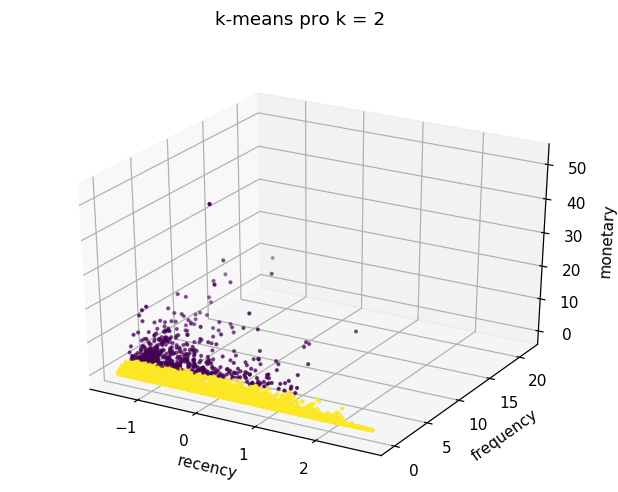

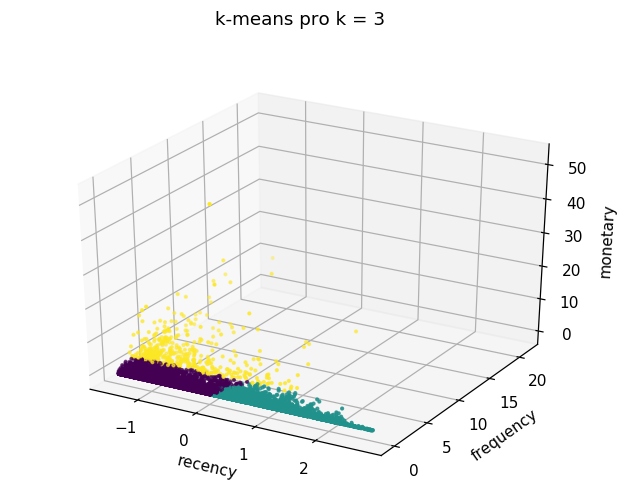

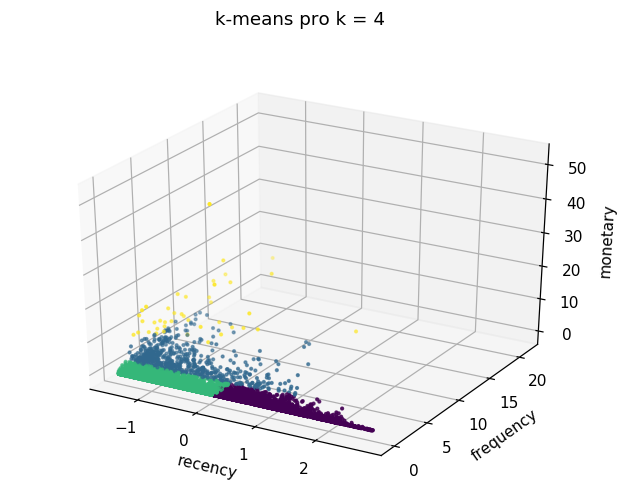

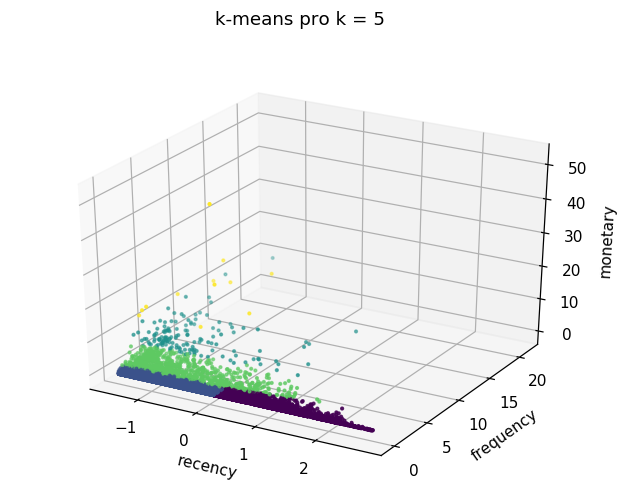

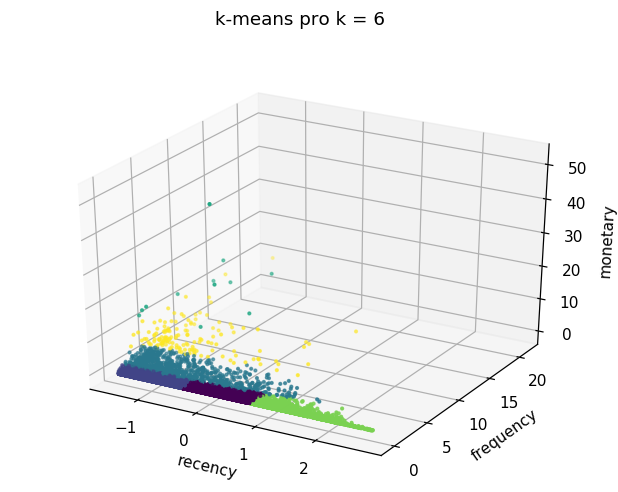

In [111]:
ss = StandardScaler()
srfm = pd.DataFrame(ss.fit_transform(rfm), columns = ["recency", "frequency", "monetary"])
scaled_predictions = plot_kmeans(srfm)

Grafy výše naznačují, že vhodné $k$ bude alespoň $4$, pro $k = 4$ jsou totiž zákazníci rozděleni do skupin rozlišitelných na všech osách. Prozatím tedy vybereme toto minimum a v případě potřeby volbu později doladíme.

Následují 2D grafy ověřující klasifikaci dat na jednotlivých osách (narozdíl od neškálovaných dat zde záleží na každém příznaku).

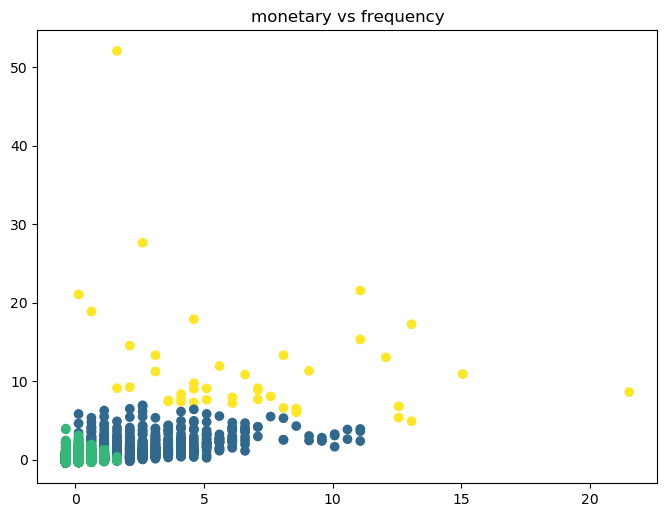

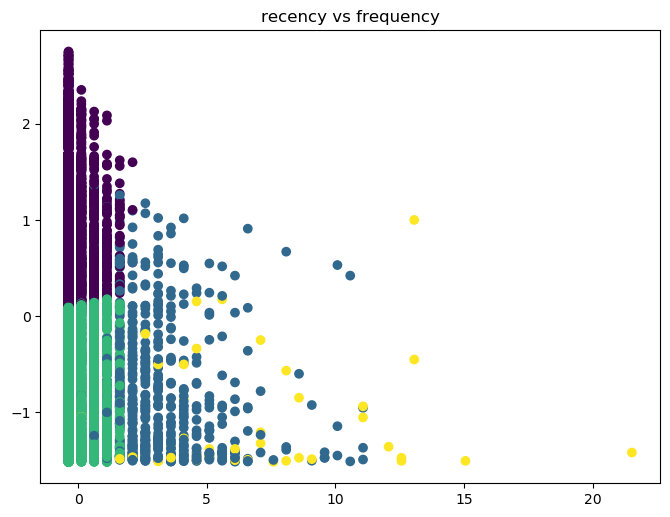

In [112]:
prediction = scaled_predictions[4 - 2]

f = plt.figure(figsize=(8,6), dpi=100)
plt.title("monetary vs frequency")
plt.scatter(srfm.frequency, srfm.monetary, c = prediction)

f = plt.figure(figsize=(8,6), dpi=100)
plt.title("recency vs frequency")
plt.scatter(srfm.frequency, srfm.recency, c = prediction)

Menší hračka - interaktivní 3D graf přeškálovaných dat obarvený podle shlukování pro $k = 4$.

In [126]:
df = srfm
prediction = scaled_predictions[4 - 2]

f = pylab.figure()
pylab.style.use("dark")
pylab.xlabel("recency")
pylab.ylabel("frequency")
pylab.zlabel("monetary")
pylab.scatter(
    df.recency.array, df.frequency.array, df.monetary.array,
    color = colours[prediction + 0],
    size = 15,
    marker = "point_2d"
)
f

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

# Interpretace shluků

In [132]:
df = srfm.copy()
df["cluster"] = scaled_predictions[4 - 2]
df.groupby("cluster").mean()

,recency,frequency,monetary
cluster,,,
0,0.953542,-0.234440,-0.168610
1,-0.792569,3.095718,1.782195
2,-0.741565,-0.130904,-0.097199
3,-1.033469,6.735959,11.793051


Superstar zákazníci jsou ti s nejnižší `recency`, nejvyšší `frequency` a nejvyšší `monetary`. Podle průměrů příznaků této skupině odpovídá cluster číslo tři.

In [139]:
len(df[df.cluster == 3])

42

# Analýza pomocí metody silhouette

In [185]:
def silhouette_plot(title, df, k, prediction):
    f= plt.figure(figsize = (14, 7), dpi = 120)
    plt.suptitle(title)
    p = f.add_subplot()
    
    samples = silhouette_samples(df, prediction)
    
    y_offset = 20
    for i in range(k):
        cluster_samples = samples[prediction == i]
        cluster_samples.sort()
        
        cluster_size = cluster_samples.shape[0]
        y = y_offset + cluster_size
        colour = colours[i]
        
        p.fill_betweenx(
            np.arange(y_offset, y),
            0,
            cluster_samples,
            facecolor = colour,
            edgecolor = colour,
            alpha = 0.7
        )
        
        p.text(-0.06, y_offset + 0.5 * cluster_size, str(i))
        y_offset = y + 300
    
    p.set_yticks([])
    p.axvline(x = silhouette_score(df, prediction), color = "red", linestyle = "--")
    plt.show()

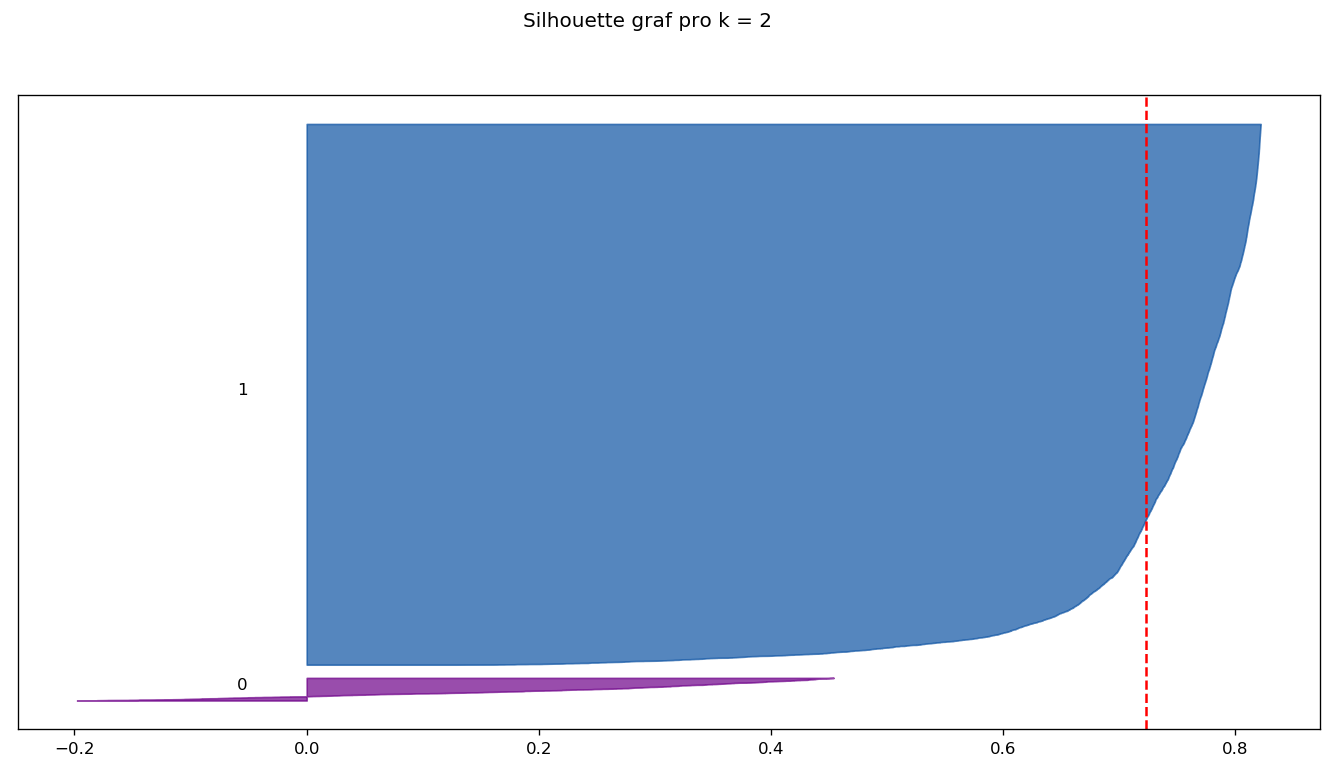

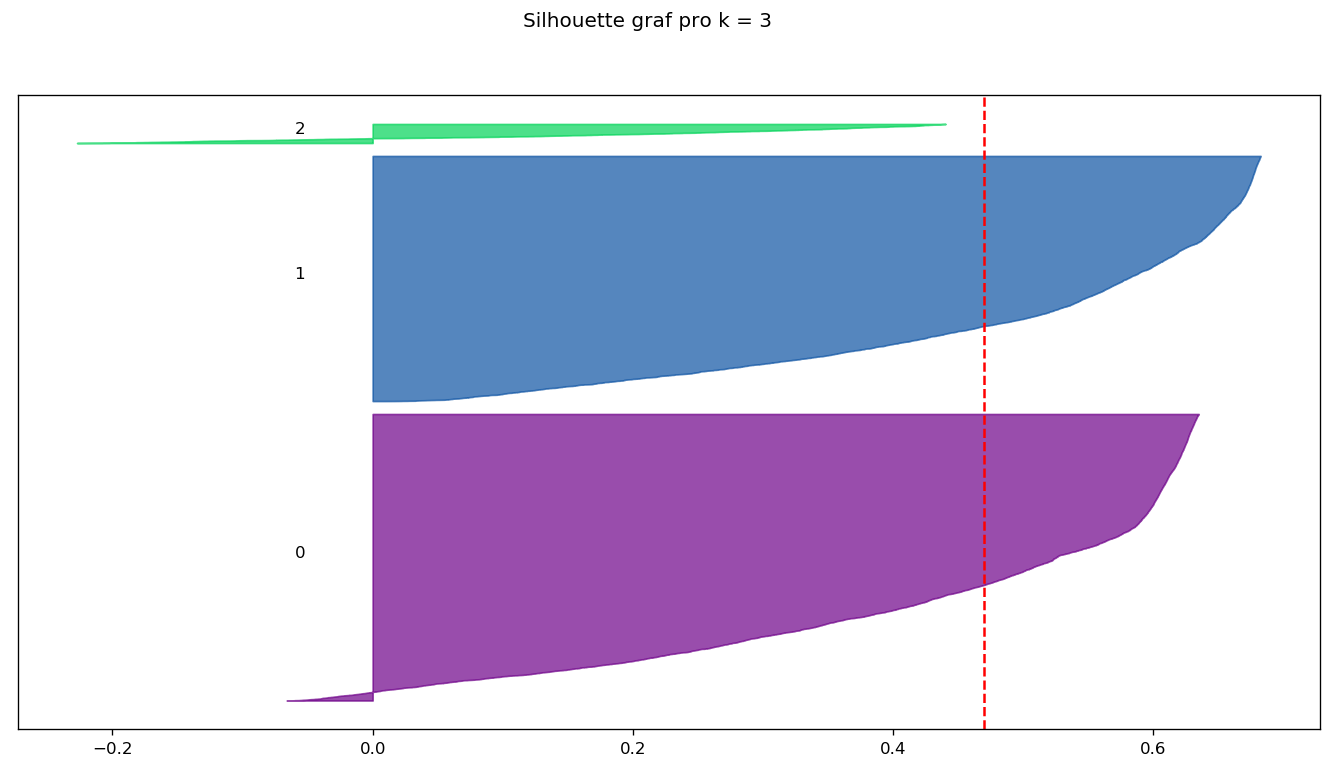

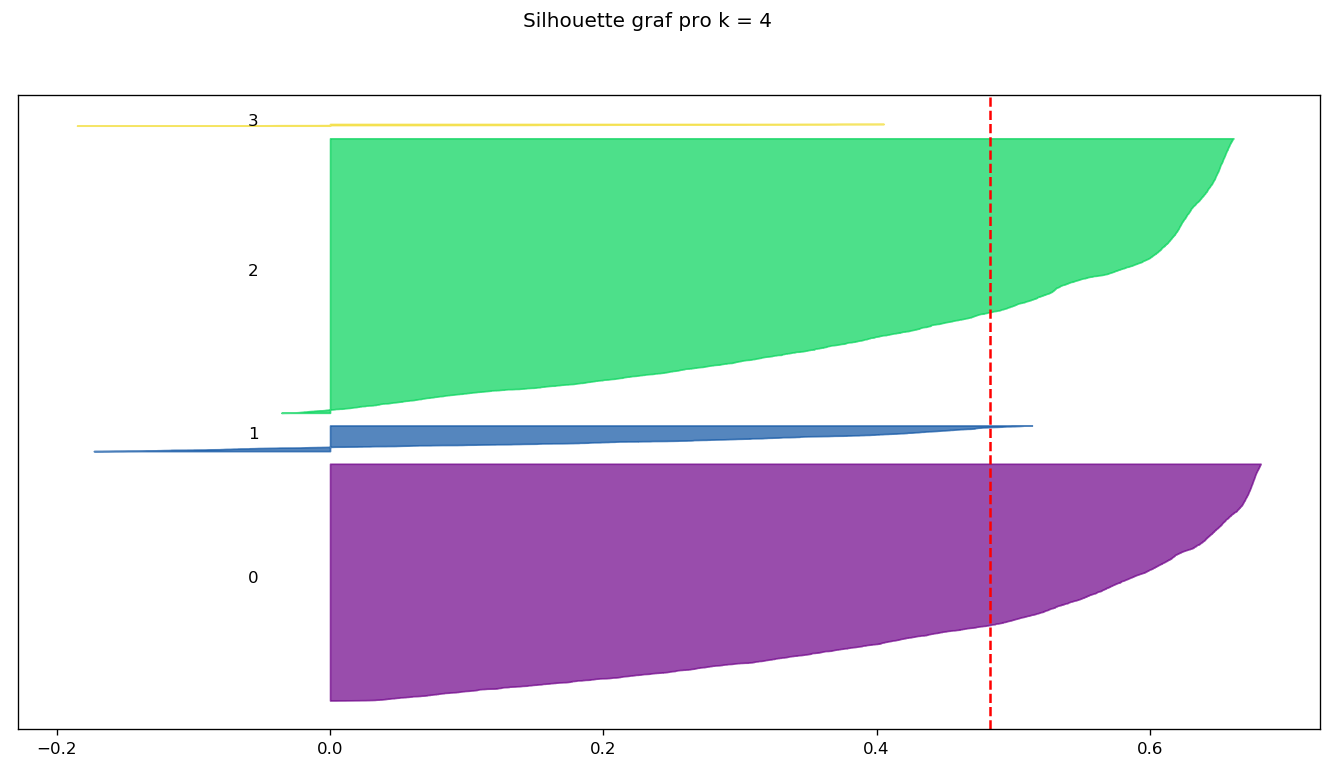

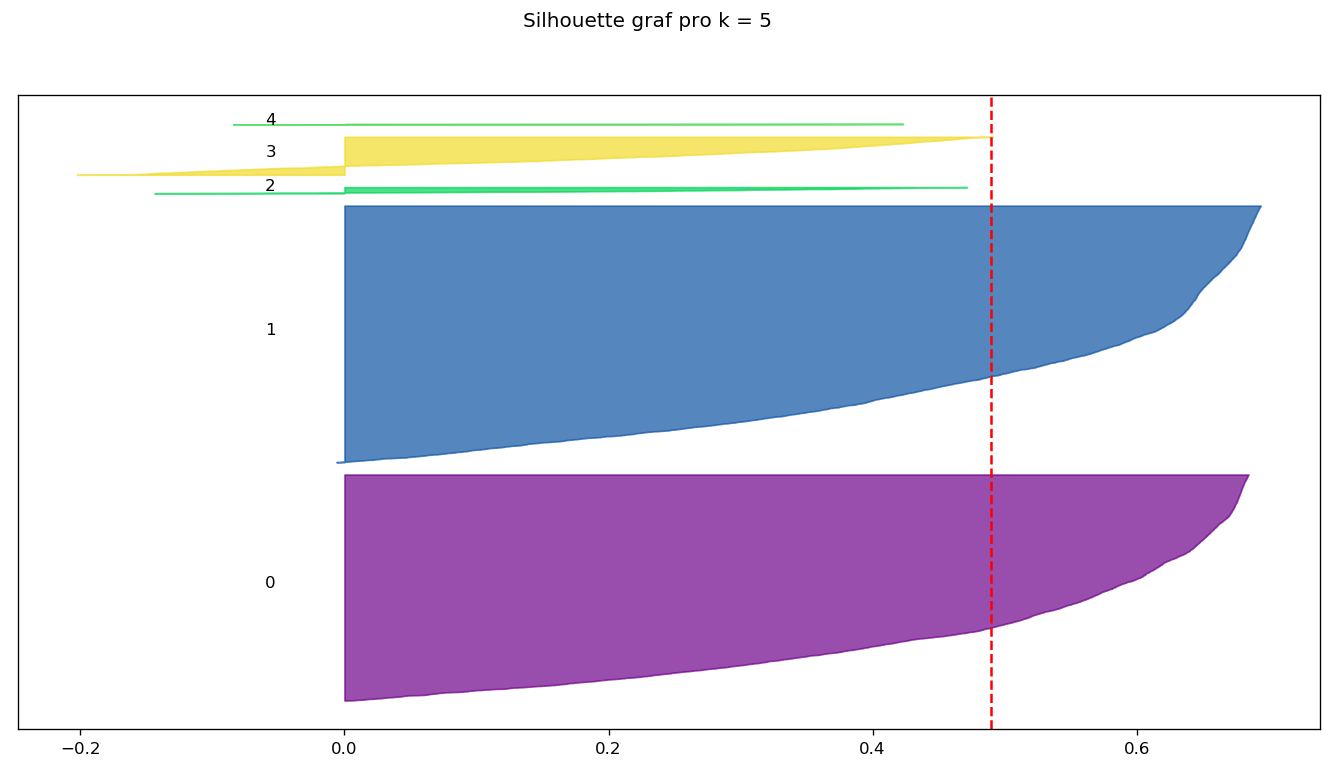

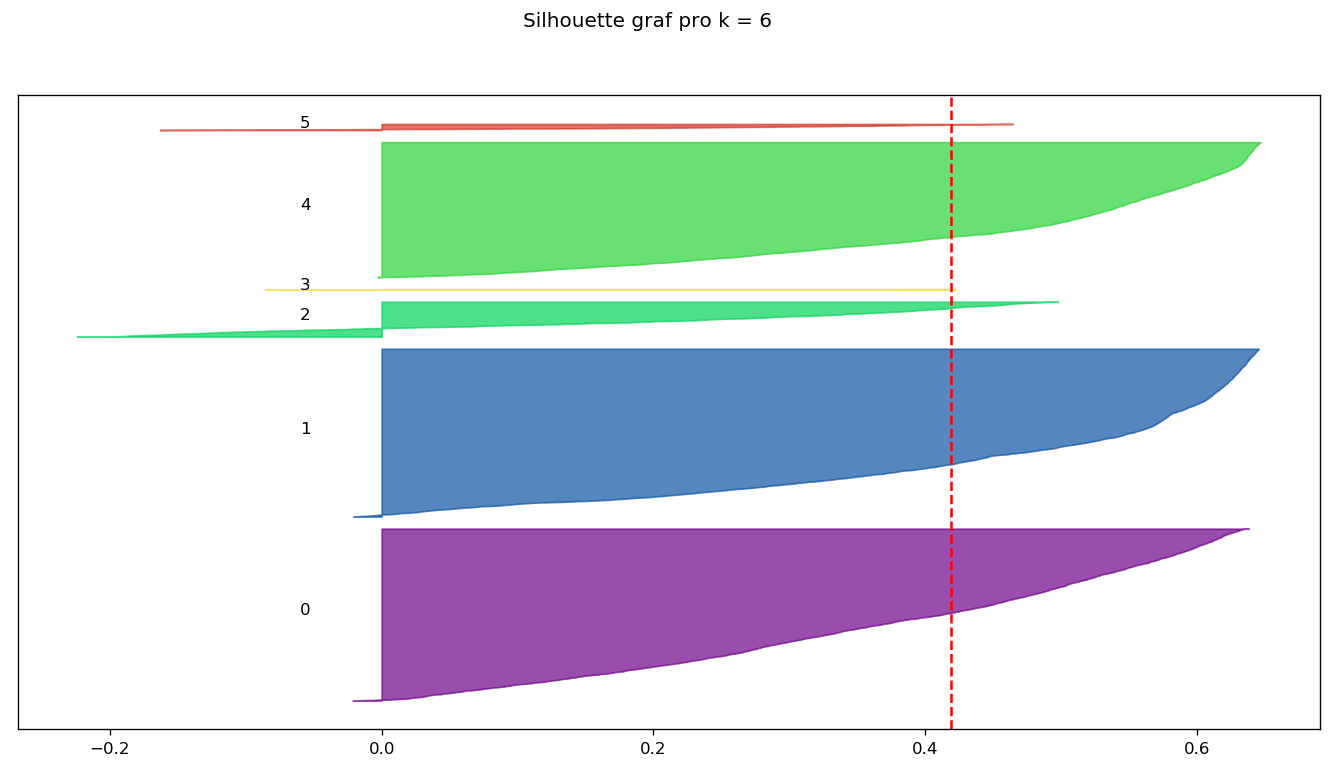

In [188]:
for i in range(5):
    silhouette_plot("Silhouette graf pro k = " + str(i + 2), srfm, i + 2, scaled_predictions[i])

Podle silhouette metody se zdá, že volba $k = 4$ byla poměrně vhodná. Červené svislice ukazují průměrná silhouette skóre pro všechny shluky. Toto průměrné skóre je očividně nejvyšší pro nejjednodušší rozdělení na pouhé dva shluky, jak se dalo předpokládat. Naopak pro vysoká $k$ začíná klesat, rozdělovat tedy dataset na více skupin (shluků) zákazníků nemá smysl.